<div style='color: #690027;' markdown="1">
    <h1>From leaf to label: stomata detection</h1> 
</div>

This notebook allows you to upload and test your own photomicrographs with the deep learning system discussed in the paper *From leaf to label: a robust automated workflow for stomata detection* by *Sofie Meeus, Jan Van den Bulcke and Francis wyffels*.
<img src="https://drive.google.com/uc?export=view&id=1g1wIt37A07yDi7w9uCza3eMt1oEPLJ5v" alt="Overview" style="width:600px;"/>
As illustrated above, your photomicrograph (A) will be divided in small overlapping patches (B) by using a sliding window approach. A deep neural network (VGG19) is trained to label these patches (C). Positively labeled patches of a photomicrograph (D) are clustered which results in the detection (E) depending on the threshold of your choice.

To start, please run the following cell by clicking the button "run" or by using shift-enter.

### Load libraries

We start by loading a few python libraries:

- [PIL](https://pillow.readthedocs.io/en/stable/): a handy Python imaging library
- [numpy](https://numpy.org): the fundamental package for scientific computing with Python
- [sklearn](https://scikit-learn.org/stable/): the scikit-learn machine learning package, more specifically the clustetring functionality
- [os](https://docs.python.org/3/library/os.html): a Python library for using operating system dependent functionality, e.g., reading, writing, listing files
- [matplotlib](https://matplotlib.org): a Python library for making graphs

In [8]:
from PIL import Image, ImageEnhance, ImageOps
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
import os
import matplotlib.pyplot as plt

In order to specify which NVidia GPU we will use we need to run the following commands. This assumes that Keras and Tensorflow are GPU enabled. See the [TensorFlow](https://www.tensorflow.org/install/gpu) documentation for more information.

In [3]:
# If there is a NVidia enable GPU run this
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

The code that produced the results presented in the manuscript is based on Tensorflow and Keras. At the time of the writing, TensorFlow 2.0 was not yet available. However, since we relied on a TF 1.0 and Keras implementation. However, the principles for training your own deep learning model stay the same and should be sufficient to get started with [Keras](https://keras.io/getting_started/intro_to_keras_for_researchers/) yourself.

In [1]:
from keras import backend as K
from keras.layers import Input, Convolution2D, Conv2D, MaxPooling2D, Activation, concatenate, Dropout, GlobalAveragePooling2D, Flatten, Dense
from keras.models import Model, load_model
from keras.engine.topology import get_source_inputs
from keras.utils import get_file
from keras.utils import layer_utils
import keras
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

Using TensorFlow backend.


### Set data

In order to train a deep learning model you need data. As discussed before, the deep learning model we discuss here will be trained based on rectangular patches. In order to get a robust model both, positive and negative examples must be presented to the system.

The data needs to be split into three parts:
- The training set, i.e., the data which is used for changing the weights of the (deep) neural network;
- The validation, i.e., the data which is used to see how well the learning process goes and to tune the model's hyperparameters;
- The test data, i.e., the data you feed to the trained system afterwards when the detector is deployed.

This notebook concerns the training and validation of the deep learning system for stomata detection, and a small dataset limited to *Carapa procera* is used for didactic purposes. This also restrains the computational needs (a full training with multiple species (cf. the paper) needs more patience.

We start by unzipping the dataset. Please make sure that you uploaded *data.zip* to the root directory of your project.

In [ ]:
!unzip 'data.zip'

In [ ]:
train_dir = "./data/training/"
val_dir = "./data/validation/"

The training and validation data consists of patches of 120 by 120 pixels. A positive patch shows a stomata:

<img src="https://drive.google.com/uc?export=view&id=11oZG14b8ZnbzooeeQpYaQeUe8wSbErmV"  width="120" />
    
A negative patch of *Carapa procera* has no stomata (or only partially) within the patch:

<img src="https://drive.google.com/uc?export=view&id=1vwcYiZDJffjQ6gXCpThwvbcCoPhgseBS"  width="120" />

In order to obtain these patches you will need labeled microphotographs (i.e., microphotographs of which you have the x,y coordinates of the center position of the stomata that are shown). Based on these labels, the patches can be cropped by using the [crop function of PIL](https://pillow.readthedocs.io/en/stable/reference/Image.html) or simply by [matrix slicing](https://numpy.org/doc/1.18/reference/arrays.indexing.html) in Python Numpy.

The preprocessor defines the data augmentation that will be applied to the dataset. This consists of random rotations, horizontal and vertical flips of the patches:

In [ ]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rotation_range=180, horizontal_flip=True, vertical_flip=True, rescale=1/255.)

Apart from the data augmentation that will be applied, we need to set a [ImageDataGenerator](https://keras.io/api/preprocessing/image/#imagedatagenerator-class) that defines the size of the patches (120 x 120 pixels), the color mode, the batch size (i.e., the number of samples used in one training iteration), the classification mode of the task (i.e., binary classification: a patch can be positive or negative), whether the data needs to be shuffled or not and the seed (starting point) of the random number generator. Additionally, you need to provide a path to the directory with the training data.

In [ ]:
batch_size = 128

In [ ]:
train_generator = train_datagen.flow_from_directory(
    directory=r"./data/training/",
    target_size=(120, 120),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="binary",
    shuffle=True,
    seed=53
)

For the purpose of validation you also need to provide a ImageDataGenerator. This is defined with the same properties as the one for training but without data augmentation.

In [ ]:
test_datagen = ImageDataGenerator(rescale=1/255.)

validation_generator = test_datagen.flow_from_directory(
        r"./data/validation/",
        target_size=(120, 120),
        color_mode="rgb",
        batch_size=batch_size,
        class_mode='binary')

### Set model parameters

We start from a [VGG19](https://arxiv.org/abs/1409.1556) with two dense layers on top. The convolutional neural layers are pre-trained on [ImageNet](https://ieeexplore.ieee.org/abstract/document/5206848). Consequently, only the dense layers are trained. These pre-trained weights can be downloaded from Keras by adding the keyword "imagenet".

In [ ]:
number_dense_neurons = 2048

In [ ]:
# VGG19 Fine tuned
from keras.applications import VGG19
# We start from a VGG19 base (convolutional neural layers) with weights pre-trained on ImageNet
vgg19_base = VGG19(weights='imagenet',include_top=False,input_shape=(120,120,3))
x = vgg19_base.output
x = Flatten()(x)
# We add our own dense layered classifier on top
x = Dense(2*number_dense_neurons,activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(number_dense_neurons,activation='relu')(x)
x = Dropout(0.5)(x)
# Output layer
x = Dense(1,activation='sigmoid')(x)

model = Model(inputs=vgg19_base.input, outputs=x)

# Only the dense layers are trained, hence, the convolutional neural layers are set not trainable:
for layer in vgg19_base.layers:
    layer.trainable = False

# How does the network looks like
model.summary()

### Train model

These parameters were optimized by using the [Adam](https://arxiv.org/pdf/1412.6980.pdf) learning rule for which the learning rate was tuned and finally set to 0.000005. Aditionally, we need to configure the training loss and metrics for validation.

In [ ]:
learning_rate = 0.000005
# Initiate Stochastic Gradient Descent with momentum, learning rate to tune
opt = keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)
# Define the losses and metrics for validation
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['binary_accuracy'])

Training can be done by using the function *fit*. We train for 50 epochs. Note that we configured our architecture in a way that only the weights of the dense layers are adjusted. 

In [ ]:
epochs = 50
history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator)

Now we are ready, our network is trained and can be deployed for use. In order to be able to use your system, you need to save the model parameters. This can be done by calling *model.save(path)* with *path*, the path to the file in which you want to save the parameters. Additionally, the *fit* returns a *history* object. This records the training and validation progress over the epochs. Consequently, this is useful to keep track of the training process, for example, when comparing multiple hyperparameter settings.

In [ ]:
# Save the Carapa procera deep learning model
model.save('my_carapa_procera_model')

# Plot the training and validation losses over time
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')

### Load a deep learning model

Now we trained a first deep learning model on the *Carapa procera*. This is stored into the object *model*. If you want to start from a saved deep learning model you just load it from a file by calling: *model = load_model(path_to_model)*.

### Image and detection parameters

The model makes use of a sliding window approach. Although not the most (computational) efficient, it's very simple to understand. The window has a size of 120 by 120 pixels and we use a step of 10 pixels. We start by loading our image:

In [21]:
demo_image = './data/Carapa_procero_demo.jpg' # you can use any other Carapa procero microphotograph

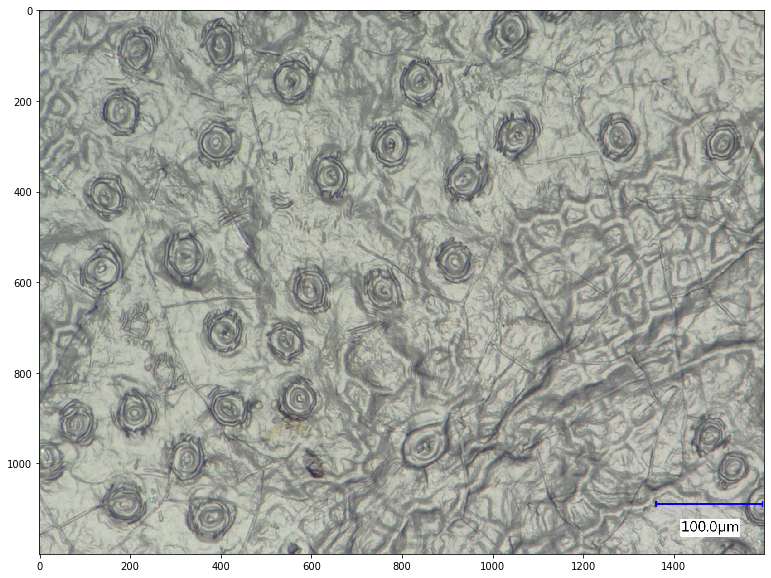

In [12]:
image = Image.open(demo_image)
fig, ax = plt.subplots(figsize=(20, 10))
image = np.array(image) # conversion to a Numpy array
ax.imshow(image)

In [13]:
shift = 10
patch_size = 120

Also part of the detection parameters is the number of slides we will do:

In [19]:
no_x_shifts = (np.shape(image)[0] - patch_size) // shift
no_y_shifts = (np.shape(image)[1] - patch_size) // shift
print("We will do "+str(no_x_shifts*no_y_shifts)+" slides. Consequently, the deep learning model will be applied to "+str(no_x_shifts*no_y_shifts)+" windows.")

We will do 15984 slides. Consequently, the deep learning model will be applied to 15984 windows.


### Classification with a deep learning model

Now that we identified all the windows, we apply the deep learning model. This is done by calling the *predict* function. The image we apply needs to be converted and normalized before applying the deep learning model. Since the output of the deep learning model is between 0 and 1, we also have to set a threshold from which we accept the output as a positive classification. The higher this threshold, the more precise the system will be in detecting stomata. However, if the threshold is too high, the system won't be able to detect stomata at all. Here we use the same threshold as determined in the paper:

In [ ]:
threshold = 0.7

In [ ]:
stomata = []
offset = patch_size // 2
for x in np.arange(no_x_shifts + 1):
    for y in np.arange(no_y_shifts + 1):
        # center of the window
        x_c = x * shift + offset
        y_c = y * shift + offset
        
        # extraction of the window and conversion before applying the deep learning model
        patch = image[x_c - offset:x_c + offset, y_c - offset:y_c + offset, :]
        patch = patch.astype('float32')
        patch /= 255
        
        # applying the deep learning model
        y_model = model.predict(np.expand_dims(patch, axis=0))

        # if the output of the network is above the 
        if y_model[0] > threshold:
            stomata.append([x_c, y_c])

### Clustering the detected stomata

All positively labeled patches are clustered by using mean shift clustering. This technique groups neighboring (or even overlapping) positively labeled patches from which the resulting stoma coordinates are derived. Therefore, we can rely on the package [MeanShift](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html) which is available in [scikit-learn](https://scikit-learn.org).

In [ ]:
bandwidth = patch_size // 2

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(stomata)
stomata = np.array([[x[1], x[0]] for x in ms.cluster_centers_]) # cluster_centers_ is inverted

### Plotting the results

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(image)
ax.plot(stomata[:,0], stomata[:,1], 'xr', alpha=0.75, markeredgewidth=3, markersize=12)